In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import scipy.stats as sts
import seaborn as sns
import statistics
from scipy import stats
%matplotlib inline
from datetime import datetime
from scipy.stats import mstats
import io
import requests

Директор Северо-Западного МРЦ хочет понять, влияет ли обучение на производительность менеджеров по продажам.

Есть несколько гипотез, как обучение влияет на производительность в зоне продаж:

1) Гипотеза 1: выручка у обученных технологии продаж менеджеров по продажам выше, чем у необученных

2) Гипотеза 2: выручка по продуктам у обученых продукту менеджеров по продажам выше, чем у необученных

3) Гипотеза 3: выручка у подразделений, чьи руководители прошли управленческое обучение, выше, чем у подразделений, чьи руководители не проходили обучение.

Проверим эти гипотезы.

# 1. Загрузим данные:

In [2]:
staff = pd.read_excel ('Staff.xlsx')

In [3]:
revenue_with_training = pd.read_excel ('Revenue_with_training.xlsx')

In [4]:
staff.head(1)

,Employee_number,id_EXEC,UL,ULName,FIO,Code,Org_unit,Org_unit_cut,Position,Functional_zone,Position_start_date,Position_expiry_date,Date_of_employment,Date_of_leave,login,MRC
0,2021,81421121,ю01,СКБ Контур,Абакумов Артемий Леонидович,5600,"Департамент по продажам и работе с клиентами, ...","ДПРК, Уральский МЦ, Свердловский РЦ, СРСЦ, Упр...",Руководитель отдела,Внедрение,2014-06-01,NaT,2010-02-16,NaT,kontur\temak,МРЦ Урал


In [5]:
revenue_with_training.head(1)

,key,login,Employee_number,id_EXEC,UL,FIO,Revenue,Year,Month,Date,Management_training_quantity,Product_training_quantity,Sales_training_quantity,Management_training_learned,Product_training_learned,Sales_training_learned,Experience_years,Month_new
0,20191kontur\gal,kontur\gal,17,75993146,ю01,Ломаева Галина Леонтьевна,50800.0,2019,1,2019-01-31,0,0,0,0,0,0,6.1,13


Переведем столбец "Revenue" в тысячи рублей:

In [6]:
revenue_with_training['Revenue_th'] = revenue_with_training.apply(lambda row: row['Revenue'] / 1000, axis=1)

In [7]:
revenue_th_with_training=revenue_with_training.drop('Revenue', axis=1)
revenue_th_with_training.head(1)

,key,login,Employee_number,id_EXEC,UL,FIO,Year,Month,Date,Management_training_quantity,Product_training_quantity,Sales_training_quantity,Management_training_learned,Product_training_learned,Sales_training_learned,Experience_years,Month_new,Revenue_th
0,20191kontur\gal,kontur\gal,17,75993146,ю01,Ломаева Галина Леонтьевна,2019,1,2019-01-31,0,0,0,0,0,0,6.1,13,50.8


# 2. Создадим датафрейм research для исследования

2.1. На основе staff создадим новый датафрейм только с нужными столбцами:

In [8]:
staff_for_merge=staff[['id_EXEC','Position','Position_start_date','Functional_zone','Code','MRC','Org_unit_cut']]
staff_for_merge.drop_duplicates(subset=['id_EXEC','Position','Position_start_date',\
                                        'Functional_zone','Code','MRC','Org_unit_cut'])
staff_for_merge.head(1)

,id_EXEC,Position,Position_start_date,Functional_zone,Code,MRC,Org_unit_cut
0,81421121,Руководитель отдела,2014-06-01,Внедрение,5600,МРЦ Урал,"ДПРК, Уральский МЦ, Свердловский РЦ, СРСЦ, Упр..."


2.2. Получившийся датафрейм объединим с revenue_with_training:

In [9]:
research = revenue_th_with_training.merge(staff_for_merge, how='inner',on='id_EXEC')

In [10]:
research.head(1)

,key,login,Employee_number,id_EXEC,UL,FIO,Year,Month,Date,Management_training_quantity,...,Sales_training_learned,Experience_years,Month_new,Revenue_th,Position,Position_start_date,Functional_zone,Code,MRC,Org_unit_cut
0,20191kontur\gal,kontur\gal,17,75993146,ю01,Ломаева Галина Леонтьевна,2019,1,2019-01-31,0,...,0,6.1,13,50.8,Заместитель руководителя управления,2013-01-01,АУП,5600,МРЦ Урал,"ДПРК, Уральский МЦ, Свердловский РЦ, СРСЦ, Упр..."


2.3. Теперь в research надо оставить только зону "Продажи", для этого в данных нужно отфильтровать нужные функциональные зоны:

In [11]:
research_sales = research[research['Functional_zone'].isin(['Активные продажи','Выездные продажи',\
                                                            'Подключения','Подключения УЦ','Телефонные продажи',\
                                                            'Телефонные продажи (моно)'])]

И теперь нужно оставить только Северо-Западный МРЦ:

In [12]:
research_final = research_sales[research_sales['MRC'].isin(['МРЦ Северо-Запад'])]

Так как данных не так много, проверим, что у нас получилось:

In [13]:
research_final.to_excel(r'C:\Users\lenta\Desktop\Личное\!Аналитика данных\!Обучение\Диплом\Диплом Булатова\Researсh.xlsx', \
                        index=False)

Все ок)

# 3. Датафрейм для исследования готов. Посмотрим данные в целом:

In [14]:
research_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2018 entries, 867 to 44759
Data columns (total 24 columns):
key                             2018 non-null object
login                           2018 non-null object
Employee_number                 2018 non-null int64
id_EXEC                         2018 non-null int64
UL                              2018 non-null object
FIO                             2018 non-null object
Year                            2018 non-null int64
Month                           2018 non-null int64
Date                            2018 non-null datetime64[ns]
Management_training_quantity    2018 non-null int64
Product_training_quantity       2018 non-null int64
Sales_training_quantity         2018 non-null int64
Management_training_learned     2018 non-null int64
Product_training_learned        2018 non-null int64
Sales_training_learned          2018 non-null int64
Experience_years                2018 non-null float64
Month_new                       2018 non-nu

Пустых данных нет, все нормально.

In [15]:
#research_final.describe()

# 4.Посмотрим на динамику выручки:

In [16]:
revenue=research_final[['Year','Month','Revenue_th']]
revenue.head()

,Year,Month,Revenue_th
867,2019,9,32.6825
868,2019,10,40.1000
869,2019,11,56.1600
870,2019,12,97.5300
917,2018,7,228.9500


In [17]:
revenue_grouped = revenue.groupby (['Year','Month']).sum()
revenue_grouped.reset_index()
revenue_grouped.head()

Revenue_th
Year Month             
2018 1      2419.663226
     2      4974.413827
     3      5491.128178
     4      6103.981224
     5      7287.857585

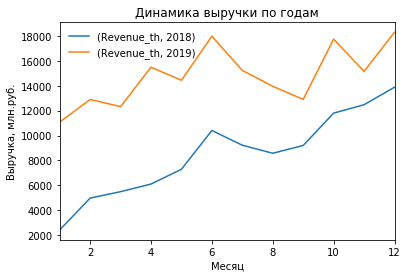

In [18]:
revenue_grouped.unstack('Year').plot()
plt.title('Динамика выручки по годам')
plt.xlabel('Месяц')
plt.ylabel('Выручка, млн.руб.')
plt.rcParams['figure.figsize'] = [10, 5]
plt.legend(loc='upper left', frameon = False)

# 5. Теперь посмотрим на данные по обучению:

In [19]:
trainings=research_final[['Year','Month','Management_training_quantity','Product_training_quantity','Sales_training_quantity']]
trainings.head()

,Year,Month,Management_training_quantity,Product_training_quantity,Sales_training_quantity
867,2019,9,0,3,4
868,2019,10,0,0,1
869,2019,11,0,0,1
870,2019,12,0,0,0
917,2018,7,0,0,0


In [20]:
trainings_grouped = trainings.groupby (['Year','Month']).sum()
trainings_grouped.reset_index()
trainings_grouped.head()

Management_training_quantity  Product_training_quantity  \
Year Month                                                            
2018 1                                 0                          3   
     2                                 3                          4   
     3                                 1                          7   
     4                                 1                          5   
     5                                 2                          0   

            Sales_training_quantity  
Year Month                           
2018 1                           20  
     2                            1  
     3                           16  
     4                           27  
     5                           20

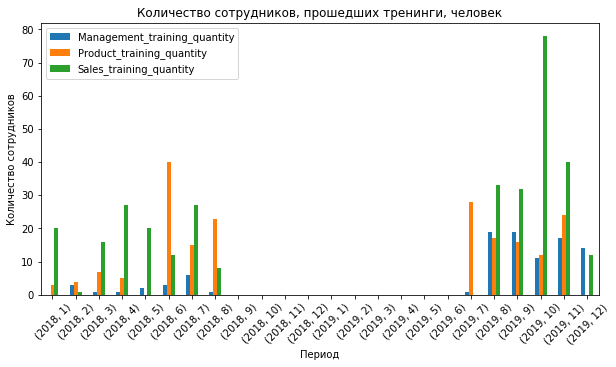

In [21]:
trainings_grouped.plot(kind='bar', rot=45)
plt.title('Количество сотрудников, прошедших тренинги, человек')
plt.xlabel('Период')
plt.ylabel('Количество сотрудников')
plt.legend(loc='upper left')
plt.rcParams['figure.figsize'] = [10,5]


В 2018 году тренинги проводились в первой половине года, в 2019 году - во второй. Самое большое количество тренингов проводится по технологии продаж (Sales_training), далее - продуктовое обучение (Product_training) и обучение для руководителей отделов продаж (Management_training).

# 6. Проверка гипотезы 1: выручка у обученных технологии продаж менеджеров по продажам выше, чем у необученных

Выберем из research данные по менеджерам по продажам

In [22]:
hypothesis_one = research_final[research_final['Position'].isin(['Менеджер по продажам'])]


In [23]:
len(hypothesis_one)

1585

В исследовании большое значение имеют данные по выручке сотрудников. Посмотрим, как распределены данные:

Можно посмотерть вот так:

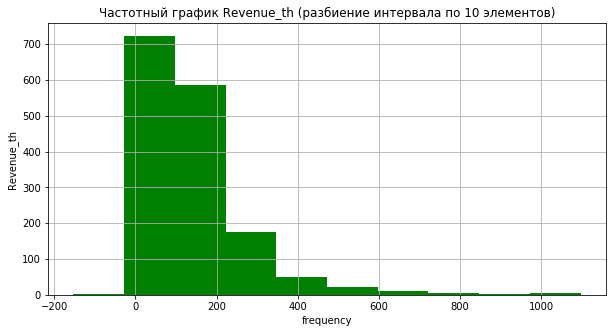

In [24]:
n, bins, patches = plt.hist(hypothesis_one['Revenue_th'], 10, facecolor='g')

plt.xlabel('frequency')
plt.ylabel('Revenue_th')
plt.title('Частотный график Revenue_th (разбиение интервала по 10 элементов)')
plt.grid(True)
plt.show()

Или вот так:

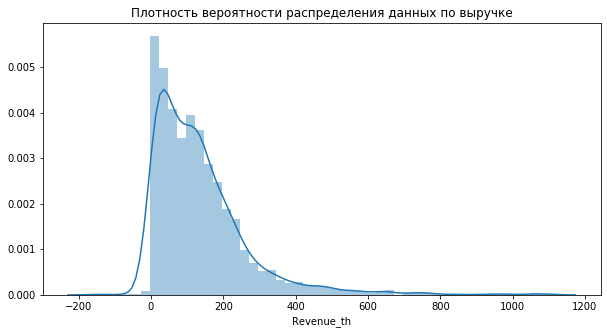

In [25]:
revenue = hypothesis_one['Revenue_th']
sns.distplot(revenue)
plt.title('Плотность вероятности распределения данных по выручке')
plt.show()

Судя по графику, распределение далеко от нормального, есть выбросы. Кроме того, есть минусовые значения.

Сначала удалим минусовые значения:

In [26]:
hypothesis_one = hypothesis_one[(hypothesis_one['Revenue_th']>=0)]
len(hypothesis_one)

1577

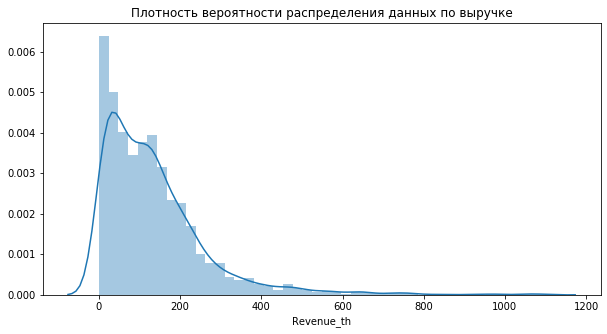

In [27]:
revenue = hypothesis_one['Revenue_th']
sns.distplot(revenue)
plt.title('Плотность вероятности распределения данных по выручке')
plt.show()

Распределение все равно далеко от нормального. Это связано с тем, что структура выручки неоднородна.

А если взять одно подразделение?

In [28]:
hypothesis_one = hypothesis_one[(hypothesis_one['Code']== 4500)]
len(hypothesis_one)

861

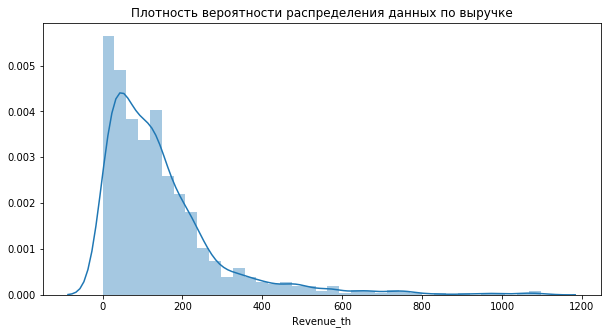

In [29]:
revenue = hypothesis_one['Revenue_th']
sns.distplot(revenue)
plt.title('Плотность вероятности распределения данных по выручке')
plt.show()

Теперь определимся с выбросами:

In [30]:
statistics.mean(revenue)

147.43869799613242

In [31]:
statistics.pstdev(revenue)

152.4082715354044

Посчитаем количество элементов, лежащих в промежутке, выходящем за интервалы mean +/- 2*sigma, где sigma - среднеквадратическое отклонение, mean - мат ожидание

In [32]:
mean = statistics.mean(revenue)
sigma = statistics.pstdev(revenue)
count_left = revenue[revenue<=mean-3*sigma].count()
print('Количество элементов меньше mean-3*sigma: ', count_left)
count_right = revenue[revenue>=mean+3*sigma].count()
print('Количество элементов больше mean+3*sigma: ', count_right)

Количество элементов меньше mean-3*sigma:  0
Количество элементов больше mean+3*sigma:  20


Итого 20 выбросов в данных по выручке, которые больше значения 604,6635126 (mean+3*sigma), которые нужно удалить.

In [33]:
hypothesis_one = hypothesis_one[(hypothesis_one['Revenue_th']<=604.6635126)]
len(hypothesis_one)

841

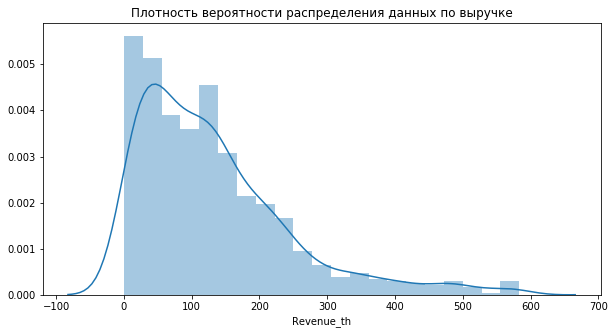

In [34]:
revenue = hypothesis_one['Revenue_th']
sns.distplot(revenue)
plt.title('Плотность вероятности распределения данных по выручке')
plt.show()

Также посмотрим на количество обученных и необученных сотрудников:

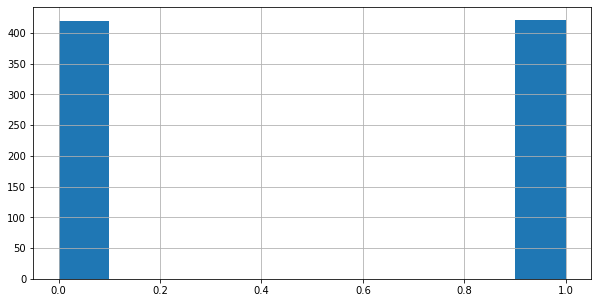

In [35]:
hypothesis_one['Sales_training_learned'].hist()

Теперь попробуем установить связь между прохождением обучения и выручкой.
Чтобы графически увидеть взаимосвязь двух переменных, необходимо построить точечный график зависимости друг от друга.

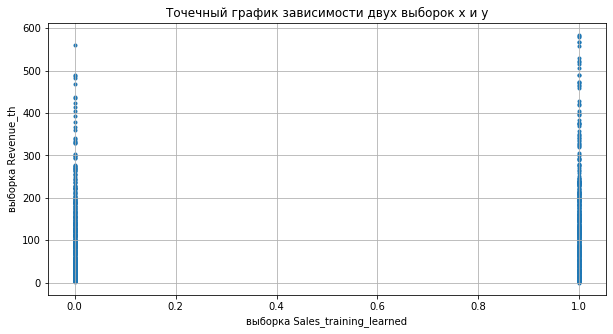

In [36]:
Sales_training_learned = hypothesis_one['Sales_training_learned']
Revenue_th = hypothesis_one['Revenue_th']
plt.xlabel('выборка Sales_training_learned')
plt.ylabel('выборка Revenue_th')
plt.title('Точечный график зависимости двух выборок x и y')
plt.grid(True)
plt.scatter(Sales_training_learned, Revenue_th, marker='.')

Кажется, что у обученных сотрудников выручка несколько выше, чем у необученных.

Но на самом деле корреляция между этими показателями (фактом прохождения обучения по технологии продаж и выруской) очень слабая.

In [47]:
corr_matrix = hypothesis_one_filtered.corr()
corr_matrix

,id_EXEC,Year,Month,Management_training_quantity,Product_training_quantity,Sales_training_quantity,Management_training_learned,Product_training_learned,Sales_training_learned,Experience_years,Month_new,Revenue_th
id_EXEC,1.000000,0.711230,0.349723,-0.065344,0.042273,0.095137,-0.016289,-0.096763,-0.263519,-0.544420,0.867097,-0.139588
Year,0.711230,1.000000,-0.193018,0.021443,-0.059176,-0.005105,0.035303,-0.059078,-0.226348,-0.032561,0.832064,0.049381
Month,0.349723,-0.193018,1.000000,0.010109,0.052792,0.050662,0.038589,0.121019,0.131507,-0.049891,0.383646,0.006927
Management_training_quantity,-0.065344,0.021443,0.010109,1.000000,0.009398,0.065129,0.553906,0.068986,0.034650,0.177408,0.025896,0.127604
Product_training_quantity,0.042273,-0.059176,0.052792,0.009398,1.000000,0.058316,0.032733,0.311619,0.057870,-0.122324,-0.025852,-0.055684
Sales_training_quantity,0.095137,-0.005105,0.050662,0.065129,0.058316,1.000000,0.018081,0.074203,0.346707,-0.147042,0.023835,-0.059627
Management_training_learned,-0.016289,0.035303,0.038589,0.553906,0.032733,0.018081,1.000000,0.183990,0.180722,0.130940,0.055041,0.126729
Product_training_learned,-0.096763,-0.059078,0.121019,0.068986,0.311619,0.074203,0.183990,1.000000,0.260649,0.225420,0.012810,0.213060
Sales_training_learned,-0.263519,-0.226348,0.131507,0.034650,0.057870,0.346707,0.180722,0.260649,1.000000,0.304334,-0.138692,0.166387
Experience_years,-0.544420,-0.032561,-0.049891,0.177408,-0.122324,-0.147042,0.130940,0.225420,0.304334,1.000000,-0.058850,0.377610


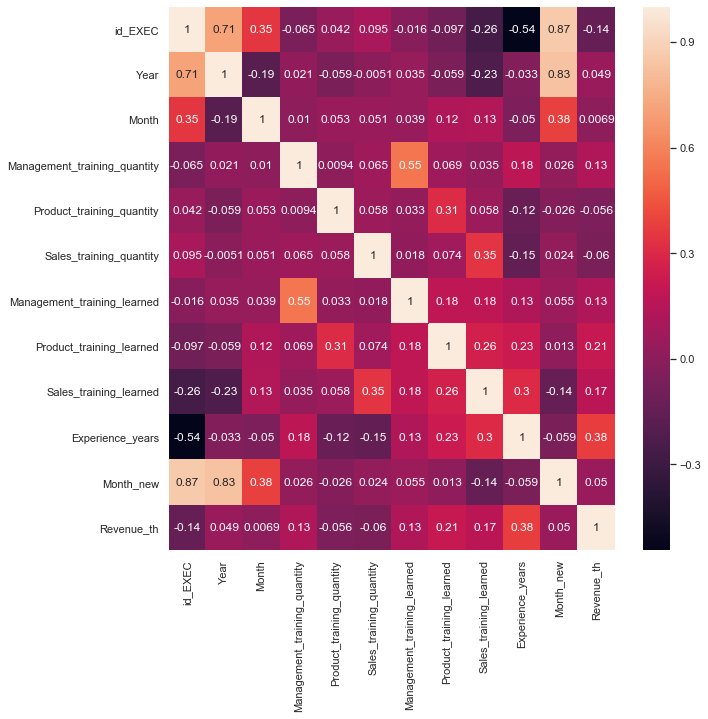

In [48]:
sns.set(rc=({'figure.figsize':(10, 10)}))
sns.heatmap(corr_matrix, annot=True)

Попробуем найти среднюю выручку обученных и необученных сотрудников и сравнить ее между собой:

Сначала найдем общие суммы выручки обученных и необученных сотрудников за каждый месяц:

In [49]:
hypothesis_one_pivot=hypothesis_one.pivot_table(index = 'Month_new', columns = 'Sales_training_learned',values = 'Revenue_th', \
                                           aggfunc = sum).reset_index()
hypothesis_one_pivot.rename(columns={0: 'revenue_unlearned',1: 'revenue_learned'}, inplace=True)
hypothesis_one_pivot
hypothesis_one_pivot.isnull().sum()

Sales_training_learned
Month_new            0
revenue_unlearned    1
revenue_learned      0
dtype: int64

Посчитаем среднюю выручку и заменим ей пропущенные значения:

In [50]:
hypothesis_one_pivot['revenue_unlearned'].mean()

2063.849684876957

In [51]:
hypothesis_one_pivot['revenue_unlearned_rep'] = hypothesis_one_pivot['revenue_unlearned'].fillna(2063.849684876957)

In [52]:
hypothesis_one_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
Month_new                24 non-null int64
revenue_unlearned        23 non-null float64
revenue_learned          24 non-null float64
revenue_unlearned_rep    24 non-null float64
dtypes: float64(3), int64(1)
memory usage: 848.0 bytes


Теперь нужно найти количество обученных и необученных сотрудников за каждый месяц

In [53]:
hypothesis_one_pivot_tr=hypothesis_one.pivot_table(index = 'Month_new', columns = 'Sales_training_learned',values = 'id_EXEC', \
                                           aggfunc = 'nunique').reset_index()
hypothesis_one_pivot_tr.rename(columns={0: 'unlearned',1: 'learned'}, inplace=True)
hypothesis_one_pivot_tr.isnull().sum()

Sales_training_learned
Month_new    0
unlearned    1
learned      0
dtype: int64

Посчитаем среднее количество необученных сотрудников и заменим им пропущенные значения:

In [62]:
hypothesis_one_pivot_tr['unlearned'].mean()

18.26086956521739

In [63]:
hypothesis_one_pivot_tr['unlearned_rep'] = hypothesis_one_pivot_tr['unlearned'].fillna(18.26086956521739)

Объединим две таблицы:

In [67]:
hypothesis_one_final = hypothesis_one_pivot.merge(hypothesis_one_pivot_tr, how='inner',on='Month_new')
hypothesis_one_final.isnull().sum()

Sales_training_learned
Month_new                0
revenue_unlearned        1
revenue_learned          0
revenue_unlearned_rep    0
unlearned                1
learned                  0
unlearned_rep            0
dtype: int64

и отфильтруем только нужные столбцы:

In [58]:
hypothesis_one_final.columns

Index(['Month_new', 'revenue_unlearned', 'revenue_learned',
       'revenue_unlearned_rep', 'unlearned', 'learned', 'unlearned_rep',
       'Avg_revenue_unlearned', 'Avg_revenue_learned'],
      dtype='object', name='Sales_training_learned')

In [71]:
hypothesis_one_final=hypothesis_one_final[['Month_new','revenue_learned','revenue_unlearned_rep', 'learned', 'unlearned_rep']]

In [73]:
hypothesis_one_final['Avg_revenue_unlearned'] = hypothesis_one_final.apply(lambda row: \
                                            row['revenue_unlearned_rep'] / row ['unlearned_rep'], axis=1)
hypothesis_one_final['Avg_revenue_learned'] = hypothesis_one_final.apply(lambda row: \
                                            row['revenue_learned'] / row ['learned'], axis=1)

hypothesis_one_final.head()

Sales_training_learned,Month_new,revenue_learned,revenue_unlearned_rep,learned,unlearned_rep,Avg_revenue_unlearned,Avg_revenue_learned
0,1,370.275640,453.528840,11.0,3.00000,151.17628,33.661422
1,2,1308.608750,921.523500,10.0,6.00000,153.58725,130.860875
2,3,1785.266660,526.401180,17.0,3.00000,175.46706,105.015686
3,4,2131.412777,20.500000,18.0,1.00000,20.50000,118.411821
4,5,2916.135960,2063.849685,20.0,18.26087,113.02034,145.806798


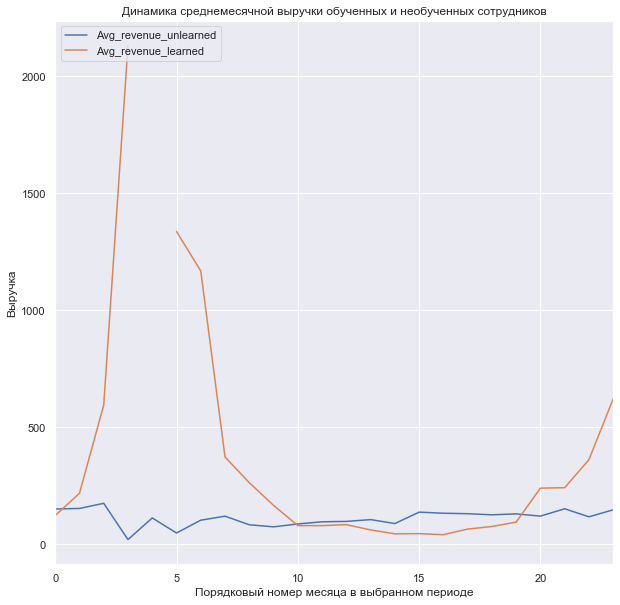

In [66]:
hypothesis_one_final_plot = hypothesis_one_final[['Avg_revenue_unlearned','Avg_revenue_learned']]
hypothesis_one_final_plot.plot()
plt.title('Динамика среднемесячной выручки обученных и необученных сотрудников')
plt.xlabel('Порядковый номер месяца в выбранном периоде')
plt.ylabel('Выручка')
plt.legend(loc='upper left')
plt.rcParams['figure.figsize'] = [10, 5]

In [74]:
corr_matrix = hypothesis_one_final.corr()
corr_matrix

Sales_training_learned,Month_new,revenue_learned,revenue_unlearned_rep,learned,unlearned_rep,Avg_revenue_unlearned,Avg_revenue_learned
Sales_training_learned,,,,,,,
Month_new,1.000000,0.383980,0.576218,0.250274,0.474434,0.228808,0.385208
revenue_learned,0.383980,1.000000,-0.268453,0.840656,-0.213864,-0.228137,0.064929
revenue_unlearned_rep,0.576218,-0.268453,1.000000,-0.507449,0.941832,0.202522,0.575026
learned,0.250274,0.840656,-0.507449,1.000000,-0.461075,-0.085438,-0.412144
unlearned_rep,0.474434,-0.213864,0.941832,-0.461075,1.000000,-0.011900,0.510008
Avg_revenue_unlearned,0.228808,-0.228137,0.202522,-0.085438,-0.011900,1.000000,-0.061321
Avg_revenue_learned,0.385208,0.064929,0.575026,-0.412144,0.510008,-0.061321,1.000000


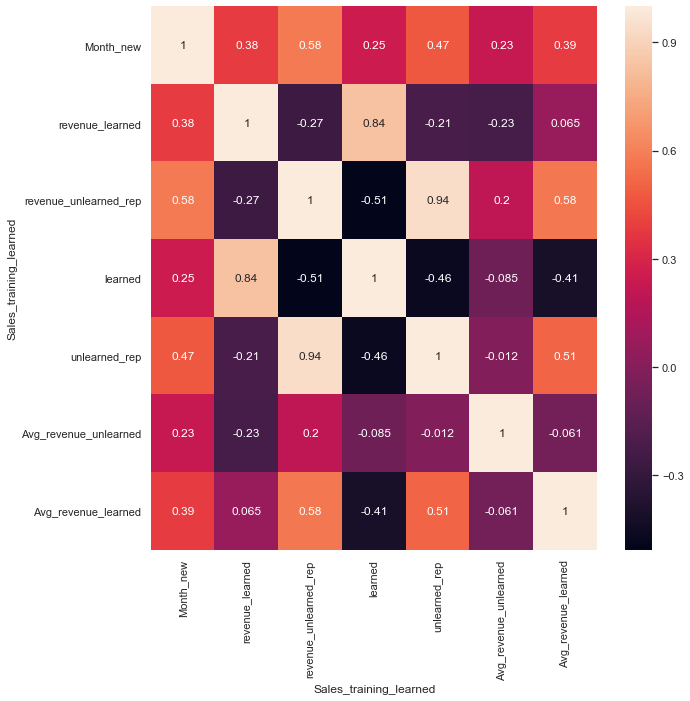

In [75]:
sns.set(rc=({'figure.figsize':(10, 10)}))
sns.heatmap(corr_matrix, annot=True)

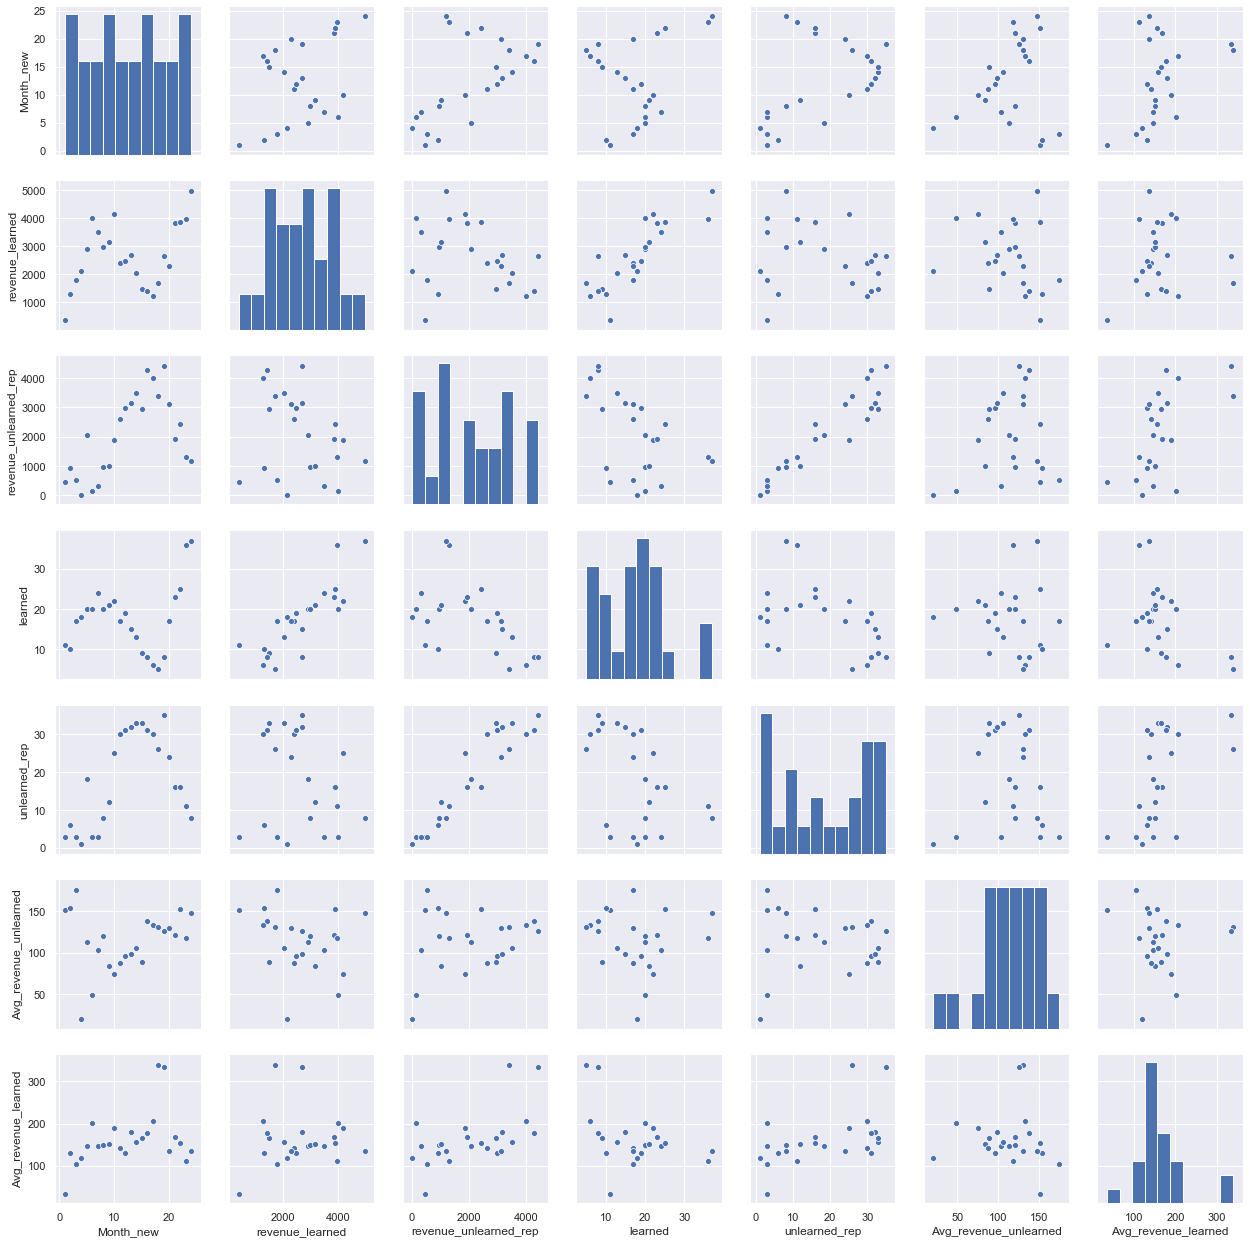

In [76]:
sns.pairplot(hypothesis_one_final, kind="scatter")